In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
class NeuralNetwork:
    def __init__(self, x, y, valX, valY, featureVal,  num_hidden, epochs, learning_rate, num_nodes_layers, activation_function, batch_size):
        self.x = x
        self.y = y
        
        self.valX = valX
        self.valY = valY
        self.featureVal = featureVal

        self.num_data = np.shape(x)[1]  # no. of data points    # no. of rows
        self.k = np.shape(x)[0]  # no. of features   # no. of cols
        self.n_out = np.shape(y)[0]

        self.batch_size = batch_size
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.num_hidden = num_hidden
        self.num_layers = num_hidden + 1  # +1 for output layer

        self.num_nodes_layers = num_nodes_layers

        # inserting input and output nodes to the list
        self.num_nodes_layers.insert(0, self.k)
        self.num_nodes_layers.append(self.n_out)

        self.leaky_slope = 0.01
        self.weights = []
        
        # parameters: weight and bias
        # weight[l] : (num_layers * num_layers-1 ) * num_layers : (no. of nodes in layer l * no. of nodes in layer (l-1)) * no. of layers
    def initialize_parameters_random(self):

        for l in range(1, self.num_layers + 1):
            self.weights.append(
                np.random.rand(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]))

    # Use this when activation function is tanh or sigmoid
    def initialize_parameters_xavier(self):

        for l in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]) * np.sqrt(
                1 / self.num_nodes_layers[l - 1]))

    # Use this when activation function is ReLU or Leaky ReLu
    def initialize_parameters_he(self):
        for l in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]) * np.sqrt(
                2 / self.num_nodes_layers[l - 1]))

    # Activation Functions
    def activation(self, x):
        if self.activation_function == "linear":
            return x
        if self.activation_function == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))
        if self.activation_function == "tanh":
            return np.tanh(x)
        if self.activation_function == "relu":
            a = np.zeros_like(x)
            return np.maximum(a, x)
        if self.activation_function == "leaky_relu":
            a = self.leaky_slope * x
            return np.maximum(a, x)

    def softmax(self, x):
        exp_x = np.exp(x)
        return exp_x / exp_x.sum(axis=0, keepdims=True)

    def gradient_activation(self, X):
        if self.activation_function == "linear":
            return np.ones_like(X)
        elif self.activation_function == "sigmoid":
            return self.activation(X) * (1 - self.activation(X))
        elif self.activation_function == "tanh":
            return (1 - np.square(X))
        elif self.activation_function == "relu":
            grad = np.zeros_like(X)
            grad[X > 0] = 1.0
            return grad
        elif self.activation_function == "leaky_relu":
            grad = np.ones_like(X)
            grad[X <= 0] = self.leaky_slope
            return grad

    def forward_propogation(self, x):
        # dim of A vector: (no. of hidden nodes * num_data) *(no. of layers)
        A = []
        Z = []
        A.append(x)
        A_prev = x

        for l in range(0, self.num_layers-1):
            z = np.matmul(self.weights[l], A_prev)
            a = self.activation(z)
            A_prev = a
            A.append(a)
            Z.append(z)
        z = np.matmul(self.weights[-1], A_prev)
        # ******* Can apply different activation to differnt nodes in last layer?****
        a = self.activation(z)
        A.append(a)
        Z.append(z)
        return (A, Z)

    def back_propogation(self, A, Z, y):

        delta_z = [None for i in range(self.num_layers)]
        delta_weight = [None for i in range(self.num_layers)]

        delta_z[-1] = (y - A[-1])
        delta_weight[-1] = np.matmul(delta_z[-1], A[-2].T)

        for l in range(self.num_layers - 2, -1, -1):
            delta_z[l] = np.multiply(np.matmul(self.weights[l + 1].T, delta_z[l + 1]), self.gradient_activation(Z[l]) )
            delta_weight[l] = np.matmul( delta_z[l], A[l].T )

        return delta_weight


    def update_weight(self, A, delta_weight):
        # weight = weight + learning_rate * error * input
        m = A[-1].shape[1]
        for l in range(self.num_layers):
            self.weights[l] = self.weights[l] + (self.learning_rate * delta_weight[l])/m

    def predict(self, x_test, isMissing):
        A,Z = self.forward_propogation(x_test)
        prediction = A[-1]
        predFinal = np.where(isMissing < 1, prediction, x_test)
        return predFinal

    def loss_function(self, y, out):
#             return (0.5 * np.mean((y - out) ** 2))
        return (np.mean(np.sum((y - out) ** 2, axis = 1)))

    def model(self):
        mini_batch = int((self.num_data) / (self.batch_size))
        
        self.initialize_parameters_random()
        
#         if self.activation_function == "linear":
#             self.initialize_parameters_random()
#         elif self.activation_function == "sigmoid" or self.activation_function == "tanh":
#             self.initialize_parameters_xavier()
#         else:
#             self.initialize_parameters_he()
        leastVal = 1000
        numBadEpoch = 0
        trainLossArr = []
        testLossArr = []
        
        for e in range(self.epochs):
            trainLossBatch = []
            print("Epoch =", e)
            end = 0
            for n in range(mini_batch + 1):
                if (n != mini_batch):
                    start = n * self.batch_size
                    end = (n + 1) * self.batch_size
                    x_ = self.x[:, start:end]
                    y_ = self.y[:, start:end]

                else:
                    if ((self.num_data % self.batch_size) != 0):
                        x_ = self.x[:, end:]
                        y_ = self.y[:, end:]
                    else:
                        break

                A,Z = self.forward_propogation(x_)
                delta_weight = self.back_propogation(A, Z, y_)
                self.update_weight(A, delta_weight)
                trainLoss = self.loss_function(A[-1], y_)
                trainLossBatch.append(trainLoss)
                
            pred = self.predict(self.valX, self.featureVal)
            valLoss = self.loss_function(valY, pred)
            
            if valLoss < leastVal:
                leastVal = valLoss
                print("** Least Validation Loss")
                numBadEpoch = 0
            else:
                print("Bad Epoch!")
                numBadEpoch += 1
            if numBadEpoch == 5:
                break
            
            trainLossArr.append(sum(trainLossBatch)/len(trainLossBatch))
            testLossArr.append(valLoss)
            
            print("Train loss = ", trainLossArr[-1])
            print("Validation loss = ", valLoss)
        return trainLossArr, testLossArr

In [20]:
X_train = np.load('Data/Train/X.npy')
X_prime_train = np.load('Data/Train/X_prime.npy')
feature_info_train = np.load('Data/Train/feature_information.npy')

In [21]:
X_test = np.load('Data/Test/X.npy')
X_prime_test = np.load('Data/Test/X_prime.npy')
feature_info_test = np.load('Data/Test/feature_information.npy')

In [22]:
trainX = X_prime_train[:24130].T
trainY = X_train[:24130].T
trainFeatureInfo = feature_info_train[:24130]
valX = X_prime_train[24130:].T
valY = X_train[24130:].T
valFeatureInfo = feature_info_train[24130:].T
testX = X_prime_test.T
testY = X_test.T

In [23]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(106, 24130)
(106, 6032)
(106, 15060)


In [24]:
print(valFeatureInfo.shape)

(106, 6032)


In [25]:
nn = NeuralNetwork(trainX, trainY, valX, valY, valFeatureInfo, num_hidden= 1, epochs= 100, learning_rate=0.05, num_nodes_layers=[10],
                       activation_function="sigmoid", batch_size = 1)
trainLossArr, valLossArr = nn.model()

Epoch = 0
** Least Validation Loss
Train loss =  0.021852411092070426
Validation loss =  15.119599151380259
Epoch = 1
** Least Validation Loss
Train loss =  0.015051110340001735
Validation loss =  13.762079933121552
Epoch = 2
** Least Validation Loss
Train loss =  0.014229311422585282
Validation loss =  13.294954998404569
Epoch = 3
** Least Validation Loss
Train loss =  0.013802607043321686
Validation loss =  13.043769220506853
Epoch = 4
** Least Validation Loss
Train loss =  0.013520646375192645
Validation loss =  12.879309674188768
Epoch = 5
** Least Validation Loss
Train loss =  0.013315201647863525
Validation loss =  12.747602897373074
Epoch = 6
** Least Validation Loss
Train loss =  0.013147405838771704
Validation loss =  12.626491130295232
Epoch = 7
** Least Validation Loss
Train loss =  0.013001883164254727
Validation loss =  12.533512849791
Epoch = 8
** Least Validation Loss
Train loss =  0.012873688082417739
Validation loss =  12.472851140853665
Epoch = 9
** Least Validation L

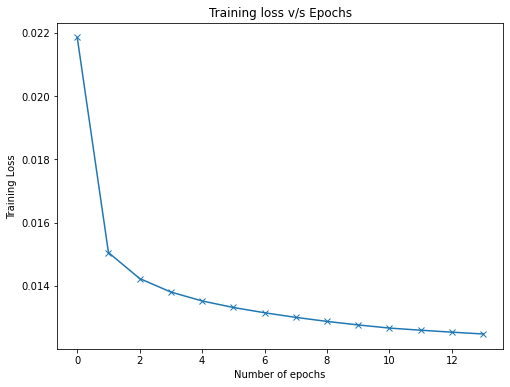

In [26]:
num_epochs = [i for i in range(len(trainLossArr))]
plt.figure(figsize=(8,6))
plt.plot(num_epochs, trainLossArr, marker='x')
plt.title("Training loss v/s Epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

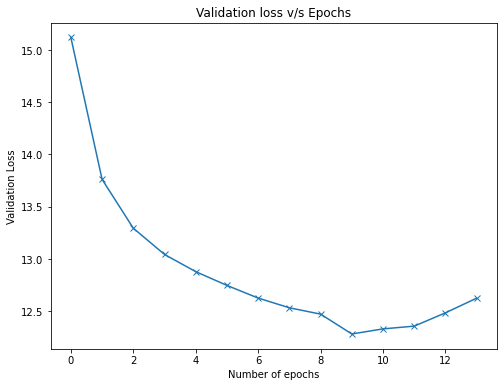

In [27]:
plt.figure(figsize=(8,6))
plt.plot(num_epochs, valLossArr, marker='x')
plt.title("Validation loss v/s Epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Validation Loss")
plt.show()

In [28]:
# nn.weights[0]

In [29]:
pred = nn.predict(testX, feature_info_test.T)

In [30]:
testErr = np.sqrt(np.mean(np.sum((pred - testY) ** 2, axis = 1)))
# testErr = nn.loss_function(pred, testY)
print("Testing error:", testErr)

Testing error: 5.620019852042843
